In [26]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

# **AA_utils**

In [27]:
def graficar_curva_elbow(X, N, GMM=False):
    plt.figure()
    Nc = range(1, N+1)
    if (GMM):
        kmeans = [GaussianMixture(n_components=i) for i in Nc]
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    if (GMM):
        score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
        scoreBIC = [kmeans[i].fit(X).bic(X) for i in range(len(kmeans))]
    else:
        score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    plt.plot(Nc, score, 'b')
    plt.xlabel('Number of Clusters')
    plt.title('Elbow Curve')
    plt.grid()
    if (GMM):
        plt.ylabel('log(verosimilitud)')
        plt.figure()
        plt.plot(Nc, scoreBIC, 'r--')
        plt.title('BIC Curve')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Bayesian information criterion')
        plt.grid()
    else:
        plt.ylabel('Promedio de sumas de distancias')
    plt.show()


# índice Silhouette
def graficar_indice_silhouette(X, N, GMM=False):

    plt.figure()
    Nc = range(2, N+1)
    if (GMM):
        # kmeans = [GaussianMixture(n_components=i) for i in Nc]
        print("Sin terminar silhouette para GMM")
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    score = [silhouette_score(X, kmeans[i].fit(X).predict(X))
             for i in range(len(kmeans))]
    score
    plt.plot(Nc, score)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Promedio de índice silhouette')
    plt.title('Índice silhouette para distintos K')
    plt.grid()
    plt.show()


def graficar_indice_silhouette_k(X, n_clusters):

    # Compute the silhouette scores for each sample
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    plt.figure()
    ax1 = plt.gca()
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot para cada Cluster.")
    ax1.set_xlabel("Coeficientes silhouette")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


def graficar_GMM(data, modelo, labels=False, probs=False):
    # display predicted scores by the model as a contour plot
    cant_points = 200
    x = np.linspace(min(data[:, 0])*0.9, max(data[:, 0])*1.1, cant_points)
    y = np.linspace(min(data[:, 1])*0.9, max(data[:, 1])*1.1, cant_points)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    if (probs):
        Z = np.exp(modelo.score_samples(XX))
    else:
        Z = -modelo.score_samples(XX)
    Z = Z.reshape(X.shape)

    centros = modelo.means_
    cant_gauss = centros.shape[0]
    if (probs):
        CS = plt.contour(X, Y, Z, levels=np.linspace(
            0, np.max(Z), cant_gauss*10),  linewidths=2)
        plt.title('Probabilidades de la GMM')
    else:
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                         levels=np.logspace(0, 3, 20),  linewidths=2)
        plt.title('Negative log-likelihood de la GMM')
    plt.colorbar(CS, shrink=0.5)
    if (labels):
        etiq = modelo.predict(data)
        plt.scatter(data[:, 0], data[:, 1], s=30, c=etiq)
    else:
        plt.scatter(data[:, 0], data[:, 1], s=30)
    plt.scatter(centros[:, 0], centros[:, 1],
                marker='o', c='red', s=100, alpha=0.8)
    plt.grid()
    plt.axis('tight')
    plt.show()


def visualizar_clustering_2D(data, labels, centers):
    values = data.to_numpy()
    plt.figure()
    plt.scatter(values[:, 0], values[:, 1], c=labels, s=50, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='*', c='red', s=600, alpha=0.8)
    plt.show()


def graficar_DBSCAN_2D(data, labels, db, EPS, MINSAM, n_clusters_):
    plt.figure()
    noise_maks = labels == -1
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    # plot RUIDO
    x = data[noise_maks]  # datos RUIDO (outliers)
    plt.scatter(x[:, 0], x[:, 1], color=[0.2, 0.2, 0.2, 0.8],
                s=20, cmap='viridis', label='ruido', marker='x')
    # plot datos CORE en clusters
    x = data[~noise_maks & core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks &
                core_samples_mask], s=30, cmap='viridis', label='Cores')
    # plot datos NO CORE en clusters
    x = data[~noise_maks & ~core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks & ~core_samples_mask],
                s=20, cmap='viridis', label='Borders', marker='D')

    title = "eps= {}, min_samples= {}, #clusters= {}".format(
        EPS, MINSAM, n_clusters_)
    plt.title(title)
    plt.legend()
    plt.show()

# **Who Life Expentancy**

In [28]:
df = pd.read_csv("https://raw.githubusercontent.com/KevinFDI/IML_Practica_4/main/datasets/who_life_expectancy.csv") 


Con este comando se pueden ver los primeros datos en el dataframe.

In [29]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Renombro las columnas dado que algunas tenían un espacio adelante o atrás.

In [30]:
df.rename(columns={
    "Life expectancy ": "Life_Expectancy",	
    "Adult Mortality": "Adult_Mortality",	
    "infant deaths": "Infant_Deaths",	
    "percentage expenditure": "Percentage_Expenditure",	
    "Hepatitis B": "Hepatitis_B",	
    "Measles ": "Measles", 
    " BMI ": "BMI", 
    "under-five deaths ": "Under_Five_Deaths",
    "Total expenditure": "Total_Expenditure",	
    " HIV/AIDS": "HIV/AIDS",
    "Diphtheria ": "Diphtheria",		
    " thinness  1-19 years": "Thinness_1-19_years",
    " thinness 5-9 years": "Thinness_5-9_years",
    "Income composition of resources": "Income_Composition_of_Resources"
    },
    inplace=True)

# Como comentario en el TP 2, me comentaste la posibilidad de usar la siguiente formula pero no pude ejecutarla porque me saltaba error: 
    # re.sub(' ', '_', texto) <--- reemplaza espacio por guion bajo
    # texto.rstrip() <----- elimina todos los espacios en blanco al final

Sumo los valores nulos de cada columna

In [31]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life_Expectancy                     10
Adult_Mortality                     10
Infant_Deaths                        0
Alcohol                            194
Percentage_Expenditure               0
Hepatitis_B                        553
Measles                              0
BMI                                 34
Under_Five_Deaths                    0
Polio                               19
Total_Expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
Thinness_1-19_years                 34
Thinness_5-9_years                  34
Income_Composition_of_Resources    167
Schooling                          163
dtype: int64

Elimino los valores nulos.

In [32]:
df.dropna(inplace = True)

Compruebo que se hayan eliminado.

In [33]:
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life_Expectancy                    0
Adult_Mortality                    0
Infant_Deaths                      0
Alcohol                            0
Percentage_Expenditure             0
Hepatitis_B                        0
Measles                            0
BMI                                0
Under_Five_Deaths                  0
Polio                              0
Total_Expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
Thinness_1-19_years                0
Thinness_5-9_years                 0
Income_Composition_of_Resources    0
Schooling                          0
dtype: int64

Elimino las columnas Country, Year y Status

In [34]:
df = df.drop(["Country", "Year",	"Status"], axis=1)

Con el describe se puede ver un análisis estadístico rápido de las variables.

In [35]:
round(df.describe(), 2)

,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,BMI,Under_Five_Deaths,Polio,Total_Expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness_1-19_years,Thinness_5-9_years,Income_Composition_of_Resources,Schooling
count,1649.0,1649.00,1649.00,1649.00,1649.00,1649.00,1649.00,1649.00,1649.00,1649.00,1649.00,1649.00,1649.00,1649.00,1.649000e+03,1649.00,1649.00,1649.00,1649.00
mean,69.3,168.22,32.55,4.53,698.97,79.22,2224.49,38.13,44.22,83.56,5.96,84.16,1.98,5566.03,1.465363e+07,4.85,4.91,0.63,12.12
std,8.8,125.31,120.85,4.03,1759.23,25.60,10085.80,19.75,162.90,22.45,2.30,21.58,6.03,11475.90,7.046039e+07,4.60,4.65,0.18,2.80
min,44.0,1.00,0.00,0.01,0.00,2.00,0.00,2.00,0.00,3.00,0.74,2.00,0.10,1.68,3.400000e+01,0.10,0.10,0.00,4.20
25%,64.4,77.00,1.00,0.81,37.44,74.00,0.00,19.50,1.00,81.00,4.41,82.00,0.10,462.15,1.918970e+05,1.60,1.70,0.51,10.30
50%,71.7,148.00,3.00,3.79,145.10,89.00,15.00,43.70,4.00,93.00,5.84,92.00,0.10,1592.57,1.419631e+06,3.00,3.20,0.67,12.30
75%,75.0,227.00,22.00,7.34,509.39,96.00,373.00,55.80,29.00,97.00,7.47,97.00,0.70,4718.51,7.658972e+06,7.10,7.10,0.75,14.00
max,89.0,723.00,1600.00,17.87,18961.35,99.00,131441.00,77.10,2100.00,99.00,14.39,99.00,50.60,119172.74,1.293859e+09,27.20,28.20,0.94,20.70


# **A. Analice diferentes valores de K.**

Defino la variable a normalizar

In [36]:
data_norm = df

Normalizo

In [37]:
NORMALIZAR = 1
if (NORMALIZAR):
    scaler = StandardScaler()
    scaler.fit(data_norm)
    data_norm = scaler.transform(data_norm)

**Obtengo el k optimo**

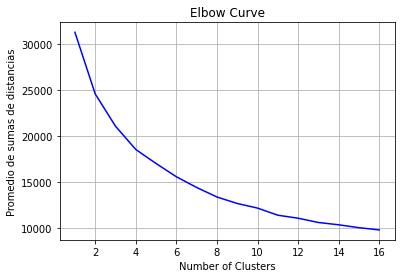

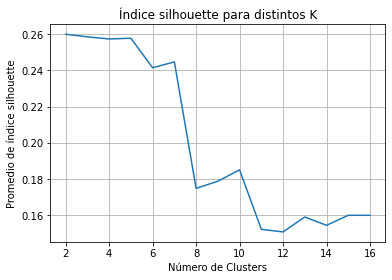

In [13]:
K_MAX = 16
graficar_curva_elbow(data_norm, K_MAX)
graficar_indice_silhouette(data_norm, K_MAX)
k_optimo = 2 # Defino la cantidad de categorías

**Punto Elbow** (punto codo).
*   Grafica el error del modelo para diferentes K.
*   El punto Elbow (si existe) se encuentra en el momento en que el error deja de bajar con la misma intensidad.

**OBSERVACIÓN: En este caso eligire k = 2 como el óptimo.**

Defino la variable a normalizar

In [14]:
df_norm_KM = df

**Normalizo**

In [15]:
scaler = MinMaxScaler()

df_norm_KM = scaler.fit_transform(df_norm_KM)

k = 2

kmeans = KMeans(n_clusters=k).fit(df_norm_KM)

centers = kmeans.cluster_centers_

columnas = df.columns

df_norm_KM = pd.DataFrame(scaler.inverse_transform(centers), columns = columnas)

df_norm_KM.to_excel("df_norm_KM.xlsx")

In [16]:
df_norm_KM = pd.read_excel("/content/df_norm_KM.xlsx") 
df_norm_KM = df_norm_KM.transpose()
round(df_norm_KM.head(20),2)

,0,1
Unnamed: 0,0.00,1.00
Life_Expectancy,61.92,74.56
Adult_Mortality,239.10,117.72
Infant_Deaths,67.73,7.50
Alcohol,2.31,6.12
Percentage_Expenditure,129.94,1104.33
Hepatitis_B,67.88,87.30
Measles,3770.77,1123.00
BMI,23.16,48.79
Under_Five_Deaths,94.00,8.76


# **B. ¿Qué ocurre si no normalizamos los datos?**

Al no normalizar, los datos del Data Frame no estaran en la misma escala por lo que, a la hora de agrupar, el modelo no será tan bueno como estando normalizado.

Defino la variable a no normalizar

In [17]:
df_sin_norm_KM = df

**Sin normalizar**

In [18]:
kmeans_sin_norm = KMeans(n_clusters=k).fit(df_sin_norm_KM)

centers_sin_norm = kmeans_sin_norm.cluster_centers_

columnas_sin_norm = df.columns

df_sin_norm_KM = pd.DataFrame(centers_sin_norm, columns = columnas_sin_norm)

df_sin_norm_KM.to_excel("df_sin_norm_KM.xlsx")

In [19]:
df_sin_norm_KM = pd.read_excel("/content/df_sin_norm_KM.xlsx") 
df_sin_norm_KM = df_sin_norm_KM.transpose()
round(df_sin_norm_KM.head(20), 2)

,0,1
Unnamed: 0,0.00,1.000000e+00
Life_Expectancy,69.31,6.528000e+01
Adult_Mortality,168.32,1.326000e+02
Infant_Deaths,28.42,1.391400e+03
Alcohol,4.54,1.700000e+00
Percentage_Expenditure,701.00,3.149000e+01
Hepatitis_B,79.39,2.100000e+01
Measles,2062.74,5.540920e+04
BMI,38.20,1.458000e+01
Under_Five_Deaths,38.76,1.840000e+03


Se observa que los datos obtenidos en el Data Frame no normalizado son diferentes a los normalizados. Esto puede generar malos agrupamientos por lo que, se necesita trabajar con la misma escala de los datos para llegar a un mejor modelo.

# **C. Intente interpretar los centros en base a las características originales.**

Cuando se hace referencia a interpretar los centros en base a las características originales entiendo que es mediante la utilización del Data Frame normalizado.

In [20]:
round(df_norm_KM.head(20),2)

,0,1
Unnamed: 0,0.00,1.00
Life_Expectancy,61.92,74.56
Adult_Mortality,239.10,117.72
Infant_Deaths,67.73,7.50
Alcohol,2.31,6.12
Percentage_Expenditure,129.94,1104.33
Hepatitis_B,67.88,87.30
Measles,3770.77,1123.00
BMI,23.16,48.79
Under_Five_Deaths,94.00,8.76


**OBSERVACIÓN:**

**Para este ejercicio opté por elegir un k = 2, es decir, dos clusters.**

**Se observa que en el centro 0 la esperanza de vida es 12 años inferior, aproximadamente, en comparación al centro 1.**

**En cuanto a la mortalidad de los adultos en el centro 0 se ve duplicado en referencia al centro 1.**

**Otro de los puntos que me llamaron la atención son el porcentaje de gastos que es sumamente superior en el centro 1, con respecto al 0. Un factor de esto puede ser que su población sea menos de la mitad que el centro 0.**


# **D. Compare los centros obtenidos con K-means y con GMM.**

**Modelo GMM**

Defino la variable a normalizar

In [21]:
df_norm_GMM = df

Normalizo

In [22]:
NORMALIZAR = 1
if (NORMALIZAR):
    scaler_GMM = StandardScaler()
    scaler_GMM.fit(df_norm_GMM)
    df_norm_GMM = scaler_GMM.transform(df_norm_GMM)

Armo el modelo GMM

In [23]:
modelo = GaussianMixture(n_components=k, verbose=True, covariance_type='full')
modelo = modelo.fit(df_norm_GMM)
centers = modelo.means_
df_norm_GMM = pd.DataFrame(scaler_GMM.inverse_transform(centers), columns=df.columns)
df_norm_GMM.to_excel("df_norm_GMM.xlsx")

Initialization 0
  Iteration 10
Initialization converged: True


**MODELO GMM NORMALIZADO**

In [24]:
df_norm_GMM = pd.read_excel("/content/df_norm_GMM.xlsx") 
df_norm_GMM = df_norm_GMM.transpose()
round(df_norm_GMM.head(20), 2)

,0,1
Unnamed: 0,0.00,1.00
Life_Expectancy,61.28,73.83
Adult_Mortality,248.24,123.04
Infant_Deaths,83.08,4.03
Alcohol,2.88,5.46
Percentage_Expenditure,132.10,1018.94
Hepatitis_B,71.61,83.51
Measles,5685.64,270.85
BMI,24.38,45.89
Under_Five_Deaths,114.02,4.82


**MODELO KMEANS NORMALIZADO**

In [25]:
round(df_norm_KM.head(20),2)

,0,1
Unnamed: 0,0.00,1.00
Life_Expectancy,61.92,74.56
Adult_Mortality,239.10,117.72
Infant_Deaths,67.73,7.50
Alcohol,2.31,6.12
Percentage_Expenditure,129.94,1104.33
Hepatitis_B,67.88,87.30
Measles,3770.77,1123.00
BMI,23.16,48.79
Under_Five_Deaths,94.00,8.76


**OBSERVACIÓN: Son dos modelos que agrupan sus centros de una forma similar. Con esto me refiero a que el centro 0 del modelo GMM se aproxima mucho al centro 1 de Kmeans y viceversa.**